In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
from scipy.stats import linregress
from scipy.stats import sem
import numpy as np

# Study data files
mouse_metadata = "data/Mouse_metadata.csv"
study_results = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata)
study_results = pd.read_csv(study_results)

# Combine the data into a single dataset
data_df = pd.merge(mouse_metadata, study_results, how='outer', on='Mouse ID')
data_df.head()

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1


In [2]:

# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

# Group data by Drug Regimen
summary_df = data_df.groupby('Drug Regimen')

# Calculate the mean, median, standard deviation, and sem for each drug
tumor_mean = summary_df['Tumor Volume (mm3)'].mean()
tumor_median = summary_df['Tumor Volume (mm3)'].median()
tumor_stdev = summary_df['Tumor Volume (mm3)'].std()
tumor_sem = summary_df['Tumor Volume (mm3)'].sem()

# Create DataFrame to summarize calculations
summary_grouped_df = pd.DataFrame({'Mean': tumor_mean, 'Median': tumor_median,
                                   'Standard Deviation': tumor_stdev, 'SEM': tumor_sem})

summary_grouped_df.head()


,Mean,Median,Standard Deviation,SEM
Drug Regimen,,,,
Capomulin,40.675741,41.557809,4.994774,0.329346
Ceftamin,52.591172,51.776157,6.268188,0.469821
Infubinol,52.884795,51.820584,6.567243,0.492236
Ketapril,55.235638,53.698743,8.279709,0.603860
Naftisol,54.331565,52.509285,8.134708,0.596466


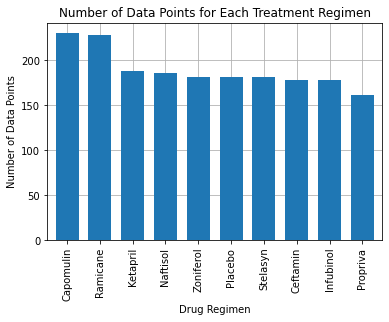

In [3]:

# Plot a bar chart (.plot.bar()) based on the amount of data points (.value_counts())
# for each treatment regimen (data_df['Drug Regimen'])
bar_plot = data_df['Drug Regimen'].value_counts().plot.bar(width=0.7, zorder=3)

# Set labels for axes
bar_plot.set_xlabel("Drug Regimen")
bar_plot.set_ylabel("Number of Data Points")
bar_plot.set_title("Number of Data Points for Each Treatment Regimen")

# Create a grid - using 'zorder' places grid behind the bars since we set their z-order higher
bar_plot.grid(zorder=0)

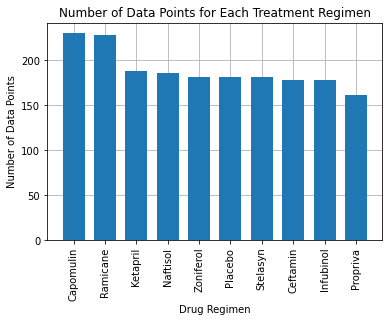

In [4]:

# Calculate the amount of data points for each drug regimen
counts = data_df['Drug Regimen'].value_counts()

# Set the x_axis to the length of the 'counts' series
x_axis = np.arange(len(counts))

# Generate a bar blot with the length of the 'counts' series
# as the amount of values on the x axis, and the corresponding values
# in the series as the y values
plt.bar(x_axis, counts, width = 0.7, zorder=3)

# Label the tick marks according to the index values in the 'counts' series
tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, counts.index.values)

# Rotate tick marks 90 degrees for visibility
plt.xticks(rotation=90)

# Set labels for axes
plt.xlabel("Drug Regimen")
plt.ylabel("Number of Data Points")
plt.title('Number of Data Points for Each Treatment Regimen')

# Create a grid - using 'zorder' places grid behind the bars since we set their z-order higher
plt.grid(zorder=0)

# Display resulting plot
plt.show()

In [5]:
# Find max timepoint for each mouse

max_tp_df = pd.DataFrame(data_df.groupby('Mouse ID')['Timepoint'].max().sort_values()).reset_index().rename(columns={'Timepoint': 'max_timepoint'})
max_tp_df

# Merge max timepoint onto data_df
merged_df = pd.merge(data_df, max_tp_df, on='Mouse ID')
merged_df.head()

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites,max_timepoint
0,k403,Ramicane,Male,21,16,0,45.000000,0,45
1,k403,Ramicane,Male,21,16,5,38.825898,0,45
2,k403,Ramicane,Male,21,16,10,35.014271,1,45
3,k403,Ramicane,Male,21,16,15,34.223992,1,45
4,k403,Ramicane,Male,21,16,20,32.997729,1,45


In [6]:
drugs = ['Capomulin', 'Ramicane', 'Infubinol', 'Ceftamin']
drug_values = []

# Locate each drug from our list 'drugs' in the orginal dataframe
for drug in drugs:
    
    temp_df = merged_df.loc[merged_df['Drug Regimen'] == drug]

    # Create subset dataframes that narrow down to rows only containing the final timepoint for each regimen
    final_volume_df = temp_df.loc[temp_df['Timepoint'] == temp_df['max_timepoint']]
    
    # Create a series that consists of all final volume values for each regimen
    values = final_volume_df['Tumor Volume (mm3)']
    drug_values.append(values)
    
    # Calculate and print the interquartile range (IQR) for each regimen
    quartiles = values.quantile([.25,.5,.75])
    lowerq = quartiles[0.25]
    upperq = quartiles[0.75]
    iqr = upperq-lowerq
    print(f'IQR for {drug}: {iqr}')
    
    # Find upper and lower bounds to help identify outliers for each regimen
    lower_bound = lowerq - (1.5*iqr)
    upper_bound = upperq + (1.5*iqr)
    print(f'Lower Bound for {drug}: {lower_bound}')
    print(f'Upper Bound for {drug}: {upper_bound}')
    
    # Quantitatively check for outliers
    outliers_count = (values.loc[(final_volume_df['Tumor Volume (mm3)'] >= upper_bound) | 
                                        (final_volume_df['Tumor Volume (mm3)'] <= lower_bound)]).count()
    print(f'Number of {drug} outliers: {outliers_count}')

IQR for Capomulin: 7.781863460000004
Lower Bound for Capomulin: 20.70456164999999
Upper Bound for Capomulin: 51.83201549
Number of Capomulin outliers: 0
IQR for Ramicane: 9.098536719999998
Lower Bound for Ramicane: 17.912664470000003
Upper Bound for Ramicane: 54.30681135
Number of Ramicane outliers: 0
IQR for Infubinol: 11.477135160000003
Lower Bound for Infubinol: 36.83290494999999
Upper Bound for Infubinol: 82.74144559000001
Number of Infubinol outliers: 1
IQR for Ceftamin: 15.577752179999997
Lower Bound for Ceftamin: 25.355449580000002
Upper Bound for Ceftamin: 87.66645829999999
Number of Ceftamin outliers: 0
